In [1]:
from PIL import Image
import numpy as np
from palette import *
from util import *
from transfer import *
from tqdm import tqdm
import cv2
import os

## Style Image

In [2]:
def preprocess_style_image(style_img, k=5):
    """
    Preprocess the style image to compute k-means clusters for its color distribution.
    """
    style_img_lab = rgb2lab(style_img)
    style_colors = style_img_lab.getdata()
    bins = {}
    for pixel in style_colors:
        bins[pixel] = bins.get(pixel, 0) + 1
    bins = sample_bins(bins)
    style_means, _ = k_means(bins, k=k, init_mean=True)
    return style_means

def color_transfer_between_images(source_img, source_means, style_means, sample_colors, sample_weight_map, sample_level=16):
    """
    Perform color transfer from the style means to the source image using precomputed clusters.
    """
    source_img_lab = rgb2lab(source_img)
    transferred_img_rgb = img_color_transfer(
        source_img_lab, source_means, style_means,
        sample_weight_map, sample_colors, sample_level
    )
    return transferred_img_rgb

In [3]:
def process_image(source_img_path, style_img_path, output_img_path, k=5):
    """
    Process a source image by applying color transfer from a style image.
    
    Args:
        source_img_path (str): Path to the source image.
        style_img_path (str): Path to the style image.
        output_img_path (str): Path to save the output image.
        k (int): Number of clusters for k-means color extraction.
    
    Returns:
        None
    """

    if not os.path.isfile(source_img_path):
        raise FileNotFoundError(f"Source image '{source_img_path}' not found.")
    if not os.path.isfile(style_img_path):
        raise FileNotFoundError(f"Style image '{style_img_path}' not found.")
    
    source_img = Image.open(source_img_path)
    style_img = Image.open(style_img_path)
    
    style_means = preprocess_style_image(style_img, k)
    
    source_img_lab = rgb2lab(source_img)
    source_colors = source_img_lab.getdata()
    bins = {}
    for pixel in source_colors:
        bins[pixel] = bins.get(pixel, 0) + 1
    bins = sample_bins(bins)
    source_means, _ = k_means(bins, k=k, init_mean=True)
    
    sample_level = 16
    sample_colors = sample_RGB_color(sample_level)
    sample_weight_map = rbf_weights(source_means, sample_colors)

    ## Color Transfer
    transferred_img_rgb = color_transfer_between_images(
        source_img, source_means, style_means,
        sample_colors, sample_weight_map, sample_level
    )
    
    transferred_img = Image.fromarray(np.uint8(transferred_img_rgb))
    transferred_img.save(output_img_path)
    print(f"Output image saved to '{output_img_path}'")


In [4]:
source_img_path = 'output/Lenna.png'
style_img_path = 'output/JohnWIck.jpg'
output_img_path = 'Lenna_JohnWick.png'

process_image(source_img_path, style_img_path, output_img_path, k=5)

using 11 cores CPU
Output image saved to 'Lenna_JohnWick.png'


In [6]:
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def compute_ssim(original_image_path, recolored_image_path):
    """
    Computes the Structural Similarity Index (SSIM) between two images.

    Parameters:
        original_image_path (str): Path to the original image.
        recolored_image_path (str): Path to the recolored image.

    Returns:
        float: SSIM value between the two images.
    """
    # Read the images
    original_image = cv2.imread(original_image_path)
    recolored_image = cv2.imread(recolored_image_path)

    # Convert images to grayscale
    original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    recolored_gray = cv2.cvtColor(recolored_image, cv2.COLOR_BGR2GRAY)

    # Compute SSIM
    ssim_value, _ = ssim(original_gray, recolored_gray, full=True)

    return ssim_value

# Example usage
# ssim_value = compute_ssim("original.jpg", "recolored.jpg")
# print("SSIM:", ssim_value)


In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def plot_images_with_varying_k(source_img_path, style_img_path, k_values, output_dir):
    """
    Plot the source image and style image in one plot, and the output images for varying k values in another plot.
    
    Args:
        source_img_path (str): Path to the source image.
        style_img_path (str): Path to the style image.
        k_values (list): List of k values to test.
        output_dir (str): Directory to save the output images and generate plots.
    """

    os.makedirs(output_dir, exist_ok=True)
    
    source_img = Image.open(source_img_path)
    style_img = Image.open(style_img_path)
    
    plt.figure(figsize=(10, 5))
    
    # Source/Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(source_img)
    plt.title("Original Image",fontsize=20)
    plt.axis("off")
    
    # Style Image
    plt.subplot(1, 2, 2)
    plt.imshow(style_img)
    plt.title("Style Image",fontsize=20)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    num_rows = (len(k_values) + 1) // 2  
    plt.figure(figsize=(10, 5 * num_rows)) 

    for i, k in enumerate(k_values):
        output_img_path = os.path.join(output_dir, f"output_k{k}.png")
        process_image(source_img_path, style_img_path, output_img_path, k=k) 

        print(f"For {k} the SSIM is ",compute_ssim(source_img_path, output_img_path))
        output_img = Image.open(output_img_path)
        
        plt.subplot(num_rows, 2, i + 1)
        plt.imshow(output_img)
        plt.title(f"Output (k={k})",fontsize=20)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


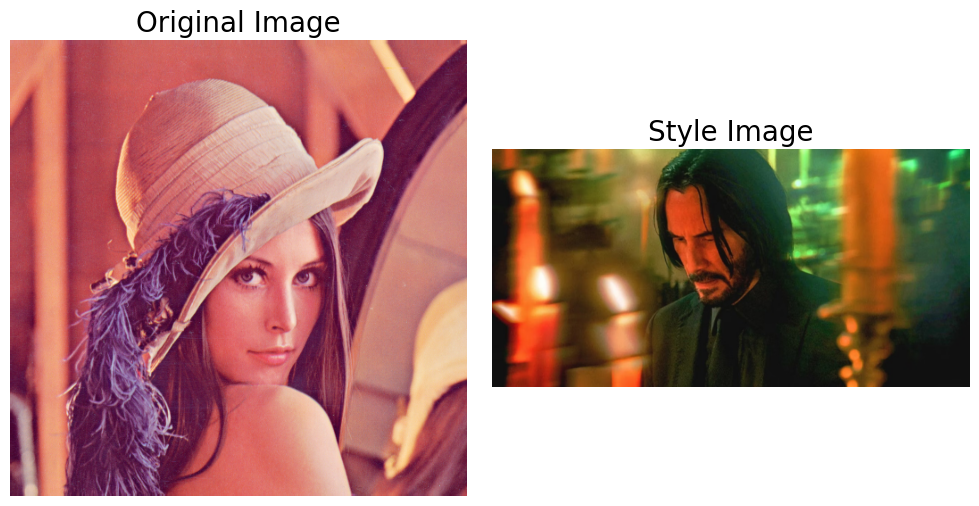

using 11 cores CPU
Output image saved to 'output/results\output_k3.png'
For {k} the SSIM is  0.867521481745938
using 11 cores CPU
Output image saved to 'output/results\output_k5.png'
For {k} the SSIM is  0.8953102616591933
using 11 cores CPU


In [8]:
source_img_path = 'output/Lenna.png'
style_img_path = 'output/JohnWIck.jpg'
output_dir = 'output/results'
k_values = [3, 5, 7, 11]

plot_images_with_varying_k(source_img_path, style_img_path, k_values, output_dir)

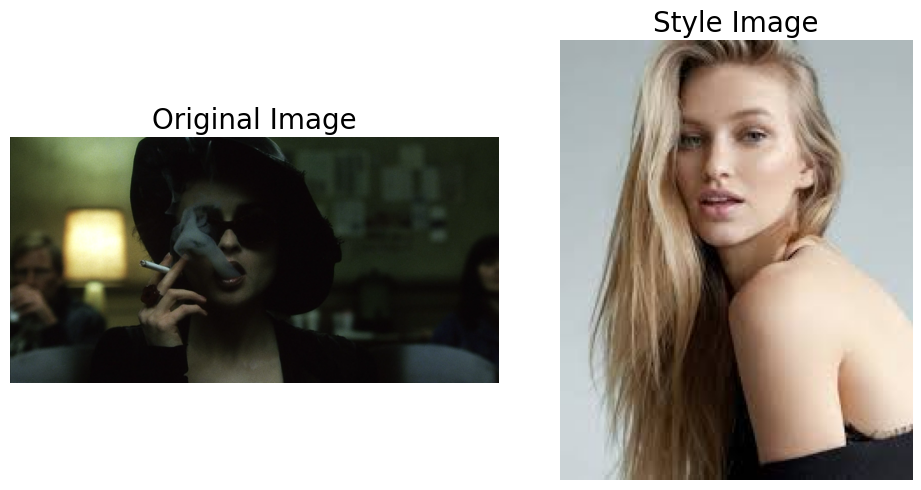

using 11 cores CPU
Output image saved to 'results_smokegirl\output_k3.png'
using 11 cores CPU
Output image saved to 'results_smokegirl\output_k5.png'
using 11 cores CPU
Output image saved to 'results_smokegirl\output_k7.png'
using 11 cores CPU
Output image saved to 'results_smokegirl\output_k11.png'


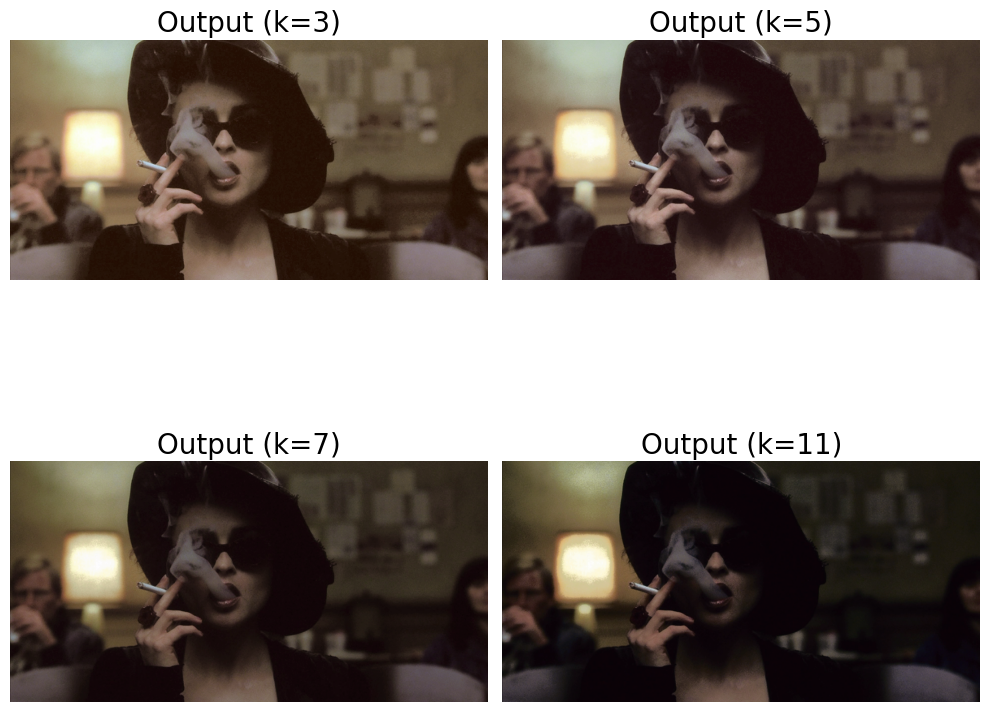

In [25]:
source_img_path = 'input/smokegirl.png'
style_img_path = 'output/Model.jpeg'
output_dir = 'results_smokegirl'
k_values = [3, 5, 7, 11]

plot_images_with_varying_k(source_img_path, style_img_path, k_values, output_dir)

## Style Video

In [13]:
def process_video(source_video_path, style_img_path, output_video_path, k=5):
    """
    Apply color transfer from a style image to each frame of a source video.
    """

    if not os.path.isfile(source_video_path):
        raise FileNotFoundError(f"Source video '{source_video_path}' not found.")
    if not os.path.isfile(style_img_path):
        raise FileNotFoundError(f"Style image '{style_img_path}' not found.")
    

    cap = cv2.VideoCapture(source_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    style_img = Image.open(style_img_path)
    style_means = preprocess_style_image(style_img, k)

    sample_level = 16
    sample_colors = sample_RGB_color(sample_level)

    with tqdm(total=frame_count, desc="Processing Frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
            source_img_lab = rgb2lab(frame_pil)
            source_colors = source_img_lab.getdata()
            bins = {}
            for pixel in source_colors:
                bins[pixel] = bins.get(pixel, 0) + 1
            bins = sample_bins(bins)
            source_means, _ = k_means(bins, k=k, init_mean=True)
            sample_weight_map = rbf_weights(source_means, sample_colors)

            # Color Transfer
            transferred_frame_rgb = img_color_transfer(
                source_img_lab, source_means, style_means,
                sample_weight_map, sample_colors, sample_level
            )
            
            transferred_frame_bgr = cv2.cvtColor(np.array(transferred_frame_rgb), cv2.COLOR_RGB2BGR)
            out.write(transferred_frame_bgr)
            
            pbar.update(1)

    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [14]:
source_video_path = 'Venice.mp4'
style_img_path = 'output/JohnWIck.jpg'
output_video_path = 'output/processed_v_johnwick.avi'

process_video(source_video_path, style_img_path, output_video_path)

Processing Frames:   0%|          | 0/151 [00:00<?, ?it/s]

using 11 cores CPU


Processing Frames:   1%|          | 1/151 [00:08<21:02,  8.42s/it]

using 11 cores CPU


Processing Frames:   1%|▏         | 2/151 [00:16<20:24,  8.22s/it]

using 11 cores CPU


Processing Frames:   1%|▏         | 2/151 [00:22<28:17, 11.39s/it]


KeyboardInterrupt: 

## Harmonization

In [1]:
import math
import numpy as np
import cv2 

type_m = ['i type', 'L type', 'mirror-L type', 'V type', 'I type', 'Y type', 'X type', 'T type'] 
type_name = ['i-type', 'L-type', 'mirror-L', 'V-type', 'I-type', 'Y-type', 'X-type', 'T-type'] 
Tm = np.array([[0,9,0,9],[0,39.6,90,9],[90,39.6,0,9],[0,46.8,0,46.8],[0,9,180,9],[0,9,180,46.8],[0,46.8,180,46.8],[0,90,0,90]])
phi = 0.38197

def shift_hue(img, deg):
    #deg = 180 * deg / 360
    #deg = (deg + 180) % 180
    deg = fit_hue(deg)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            img[i][j][0] = (img[i][j][0] + deg) % 180
def G(sigma, x):
    return math.exp(-1 * x**2 / (2 * sigma**2))
def arc_dist(a1, a2):
    return min((a1 - a2) % 360, (a2 - a1) % 360)
def arc_dist_180(a1, a2):
    return real_hue(min((a1 - a2) % 180, (a2 - a1) % 180))
def dtr(t):
    return t * math.pi / 180
def rth(t): ## radians to hue 
    return t * 90 / math.pi
def fit_hue(h):
    return 180 * (h % 360) / 360 ## 0 < h < 180
def real_hue(h):
    return 360 * (h % 180) / 180 ## 0 < h < 360
def hue_border_dist(m, alpha, hue): ## 0 < alpha, hue < 360
    ret1 = 180
    delta = abs((hue - (Tm[m][0] + alpha) + 180) % 360 - 180) # 0 < d < 180
    if delta < Tm[m][1]: 
        return 0
    else:
        ret1 = delta - Tm[m][1]
    ret2 = 180
    delta = abs((hue - (Tm[m][2] + alpha) + 180) % 360 - 180) # 0 < d < 180
    if delta < Tm[m][3]: 
        return 0
    else:
        ret2 = delta - Tm[m][3]
    return dtr(ret1) if ret1 < ret2 else dtr(ret2) ## ret > 0 (radians)
def direction(m, hue, C1, C2): ## 0 < alpha, hue < 180
    ret1 = 90
    delta = abs((hue - C1 + 90) % 180 - 90) # 0 < d < 180
    if delta < Tm[m][1]: 
        return 1
    else:
        ret1 = delta - Tm[m][1]
    ret2 = 180
    delta = abs((hue - C2 + 90) % 180 - 90) # 0 < d < 180
    if delta < Tm[m][3]: 
        return 2
    else:
        ret2 = delta - Tm[m][3]
    return 1 if ret1 < ret2 else 2 

def determine_F(img, m, alpha, weight):
    f = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            f += hue_border_dist(m, alpha, real_hue(img[i][j][0])) \
                * img[i][j][1] * weight[i][j]
    return f ## f > 0
def angle_mid(a0, a1):
    r = 0.5
    ret = 0
    if (a0 - a1) % 360 < (a1 - a0) % 360:
        ret = (a0 - ((a0 - a1) % 360) * r) % 360
    else:
        ret = (a0 + ((a1 - a0) % 360) * r) % 360
    return ret
def brent(img, m, w):
    ##### brent's method #####
    a0, a1, a2 = 0, 120, 240
    #f0, f1, f2
    f0 = determine_F(img, m, a0, w)
    f1 = determine_F(img, m, a1, w)
    f2 = determine_F(img, m, a2, w)
    if f0 < f1 and f0 < f2:
        a0, a1, a2 = a2, a0, a1
        f0, f1, f2 = f2, f0, f1
    elif f2 < f1 and f2 < f0:
        a0, a1, a2 = a1, a2, a0 
        f0, f1, f2 = f1, f2, f0 
    while (arc_dist(a2,a0) > 0.5):
        ##if abs((a1 - a0) % 360) > abs((a2 - a1) % 360):
        if arc_dist(a1, a0) > arc_dist(a2, a1):
            x = angle_mid(a0,a1)
            fx = determine_F(img, m, x, w)
            #print(a0,'\t',x,'\t',a1,'\t',a2)
            if fx < f1:
                a2, f2 = a1, f1
                a1, f1 = x, fx
            else:
                a0, f0 = x, fx
        else:
            x = angle_mid(a2,a1)
            fx = determine_F(img, m, x, w)
            #print(a0,'\t',a1,'\t',x,'\t',a2)
            if fx < f1:
                a0, f0 = a1, f1
                a1, f1 = x, fx
            else:
                a2, f2 = x, fx
    return f1, m, a1
    ##### brent's method #####
def harm_shift(H_img, m, alpha, s_w):
    w1 = 2 * dtr(Tm[m][1])
    w2 = 2 * dtr(Tm[m][3])
    ##print(w1,w2)
    sigma1 = w1 * s_w
    sigma2 = w2 * s_w
    C1 = fit_hue(Tm[m][0] + alpha)
    C2 = fit_hue(Tm[m][2] + alpha)
    for i in range(0,H_img.shape[0]):
        for j in range(0,H_img.shape[1]):
            #print(H_img[i][j])
            #if arc_dist_180(H_img[i][j][0], C1) < arc_dist_180(H_img[i][j][0], C2) :
            #print(m, H_img[i][j][0], C1, C2)
            if direction(m, H_img[i][j][0], C1, C2) == 1:
                if (C1 - H_img[i][j][0]) % 180 < (H_img[i][j][0] - C1) % 180 :
                    H_img[i][j][0] = \
                        (C1 - rth(w1)/2 * (1-G(sigma1, dtr(arc_dist_180(H_img[i][j][0],C1))))) % 180
                else:
                    H_img[i][j][0] = \
                        (C1 + rth(w1)/2 * (1-G(sigma1, dtr(arc_dist_180(H_img[i][j][0],C1))))) % 180
            else:
                if (C2 - H_img[i][j][0]) % 180 < (H_img[i][j][0] - C2) % 180 :
                    H_img[i][j][0] = \
                        (C2 - rth(w2)/2 * (1-G(sigma2, dtr(arc_dist_180(H_img[i][j][0],C2))))) % 180
                else:
                    H_img[i][j][0] = \
                        (C2 + rth(w2)/2 * (1-G(sigma2, dtr(arc_dist_180(H_img[i][j][0],C2))))) % 180
            #print(H_img[i][j])
    return H_img

def auto_palette(palette_rgb, weight): # K x 3 numpy array
    k = palette_rgb.shape[0]
    palette_rgb = palette_rgb.reshape(1,k,3)
    weight = weight.reshape(1,k)
    palette_hsv = cv2.cvtColor(palette_rgb.astype(np.ubyte), cv2.COLOR_RGB2HSV)

    Result = np.zeros((8,3))
    for m in range(0,8):
        Result[m] = brent(palette_hsv,m,weight)
        print('F =',Result[m][0],'\talpha =',Result[m][2])
    
    Result = Result[np.argsort(Result[:,0])]
    print(Result)
    m = 0
    print(m)
    M, Alpha = int(Result[m][1]), Result[m][2]
    sigma_w_ratio = 0.5
    palette_hsv = harm_shift(palette_hsv, M, Alpha, sigma_w_ratio)
    palette_rgb = cv2.cvtColor(palette_hsv,cv2.COLOR_HSV2RGB)##back to RGB
    return palette_rgb[0]


In [2]:
def harmonize_image(input_image_path, output_image_path):
    """
    Harmonizes an image based on color harmony principles.
    
    Args:
        input_image_path (str): Path to the input image file.
        output_image_path (str): Path where the harmonized image will be saved.
    """

    Img = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    if Img is None:
        raise FileNotFoundError(f"Could not read image: {input_image_path}")

    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV) # HSV space

    weight = np.ones((Img.shape[0], Img.shape[1]))

    Result = np.zeros((8, 3))  # 8 harmony types
    for m in range(8):
        Result[m] = brent(Img, m, weight)
        print(f"Type {type_m[m]}: F = {Result[m][0]}, Alpha = {Result[m][2]}")

    Result = Result[np.argsort(Result[:, 0])]
    best_harmony = Result[0]  # Best harmony
    M, Alpha = int(best_harmony[1]), best_harmony[2]
    print(f"Selected Harmony: {type_m[M]}, Alpha = {Alpha}")

    sigma_w_ratio = 0.5
    harm_shift(Img, M, Alpha, sigma_w_ratio)

    Img_harmonized = cv2.cvtColor(Img, cv2.COLOR_HSV2BGR)
    cv2.imwrite(output_image_path, Img_harmonized)
    print(f"Harmonized image saved to: {output_image_path}")


In [8]:
input_image_path = 'output/Lenna.png'
output_image_path = 'Lenna_Harmonized.png'

harmonize_image(input_image_path, output_image_path)


Type i type: F = 5952515.12510377, Alpha = 352.96875
Type L type: F = 273595.6070101249, Alpha = 347.578125
Type mirror-L type: F = 223909.80681126198, Alpha = 259.453125
Type V type: F = 96464.73800243901, Alpha = 345.234375
Type I type: F = 5949759.150949267, Alpha = 352.96875
Type Y type: F = 96423.28316021181, Alpha = 165.234375
Type X type: F = 95454.66905858627, Alpha = 345.234375
Type T type: F = 11.207740874759837, Alpha = 322.03125
Selected Harmony: T type, Alpha = 322.03125
Harmonized image saved to: Lenna_Harmonized.png


In [9]:
def plot_radial_hue(data_hue, title, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    # Create the hue wheel
    theta = np.linspace(0, 2 * np.pi, 180)  # 180 hue values
    radius = np.ones_like(theta)
    colors = [plt.cm.hsv(i / 180) for i in range(180)]

    # Plot the wheel
    for i in range(180):
        plt.polar([theta[i], theta[i]], [0, radius[i]], color=colors[i], lw=2)

    # Plot the hue distribution
    unique_hues, counts = np.unique(data_hue.flatten(), return_counts=True)
    hue_angles = unique_hues * 2 * np.pi / 180
    normalized_counts = counts / counts.max()

    for angle, r in zip(hue_angles, normalized_counts):
        plt.polar([angle, angle], [0, r], color='black', lw=1)

    plt.title(title, va='bottom')
    plt.show()

# Load and process image to HSV
def load_image_hsv(image_path):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

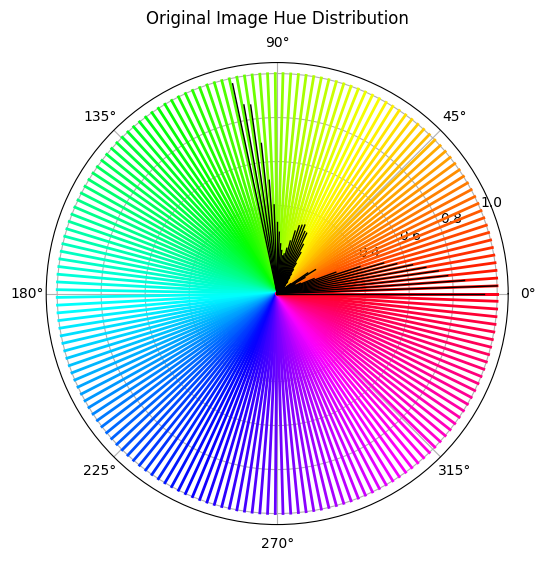

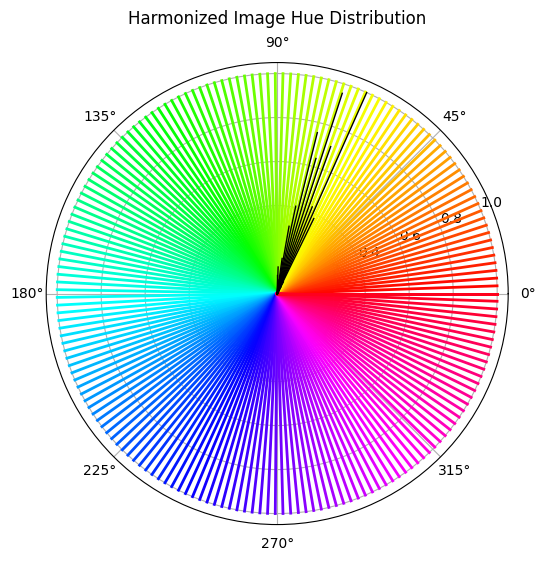

In [10]:
import matplotlib.pyplot as plt

img1_hsv = load_image_hsv(input_image_path)
img2_hsv = load_image_hsv(output_image_path)

plot_radial_hue(img1_hsv[:, :, 0], title="Original Image Hue Distribution")
plot_radial_hue(img2_hsv[:, :, 0], title="Harmonized Image Hue Distribution")


In [21]:
def harmonize_image(input_image_path, output_image_path):
    """
    Harmonizes an image based on color harmony principles and plots all types of harmonized images.
    
    Args:
        input_image_path (str): Path to the input image file.
        output_image_path (str): Path where the harmonized image will be saved.
    """

    Img = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    if Img is None:
        raise FileNotFoundError(f"Could not read image: {input_image_path}")

    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV) # HSV Space

    weight = np.ones((Img.shape[0], Img.shape[1]))

    Result = np.zeros((8, 3))  # 8 harmony types
    harmonized_images = [] 

    for m in range(8):
        print(f"Processing {type_m[m]}...")

        Result[m] = brent(Img, m, weight)
        print(f"{type_m[m]}: F = {Result[m][0]}, Alpha = {Result[m][2]}")

        Result = Result[np.argsort(Result[:, 0])]
        M, Alpha = int(Result[m][1]), Result[m][2]

        tmp_img = Img.copy()
        harm_shift(tmp_img, M, Alpha, 0.5) 

        harmonized_bgr = cv2.cvtColor(tmp_img, cv2.COLOR_HSV2BGR)
        harmonized_images.append(harmonized_bgr) 

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    axes[0, 0].imshow(cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    for i in range(8):
        row = (i + 1) // 3
        col = (i + 1) % 3
        axes[row, col].imshow(cv2.cvtColor(harmonized_images[i], cv2.COLOR_BGR2RGB))  # Convert to RGB for plotting
        axes[row, col].set_title(f'{type_name[i]}',fontsize=20)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    best_harmony = Result[0]  # Best harmony
    M, Alpha = int(best_harmony[1]), best_harmony[2]
    harm_shift(Img, M, Alpha, 0.5)
    Img_harmonized = cv2.cvtColor(Img, cv2.COLOR_HSV2BGR)
    cv2.imwrite(output_image_path, Img_harmonized)
    print(f"Harmonized image saved to: {output_image_path}")

Processing i type...
i type: F = 897458.7662606682, Alpha = 26.953125
Processing L type...
L type: F = 303996.4424172527, Alpha = 57.65625
Processing mirror-L type...
mirror-L type: F = 321240.476723005, Alpha = 264.375
Processing V type...
V type: F = 540343.2336221467, Alpha = 64.921875
Processing I type...
I type: F = 134615.89748489886, Alpha = 24.84375
Processing Y type...
Y type: F = 58875.52839698707, Alpha = 198.984375
Processing X type...
X type: F = 12929.26689008319, Alpha = 26.71875
Processing T type...
T type: F = 105290.48732983031, Alpha = 100.078125


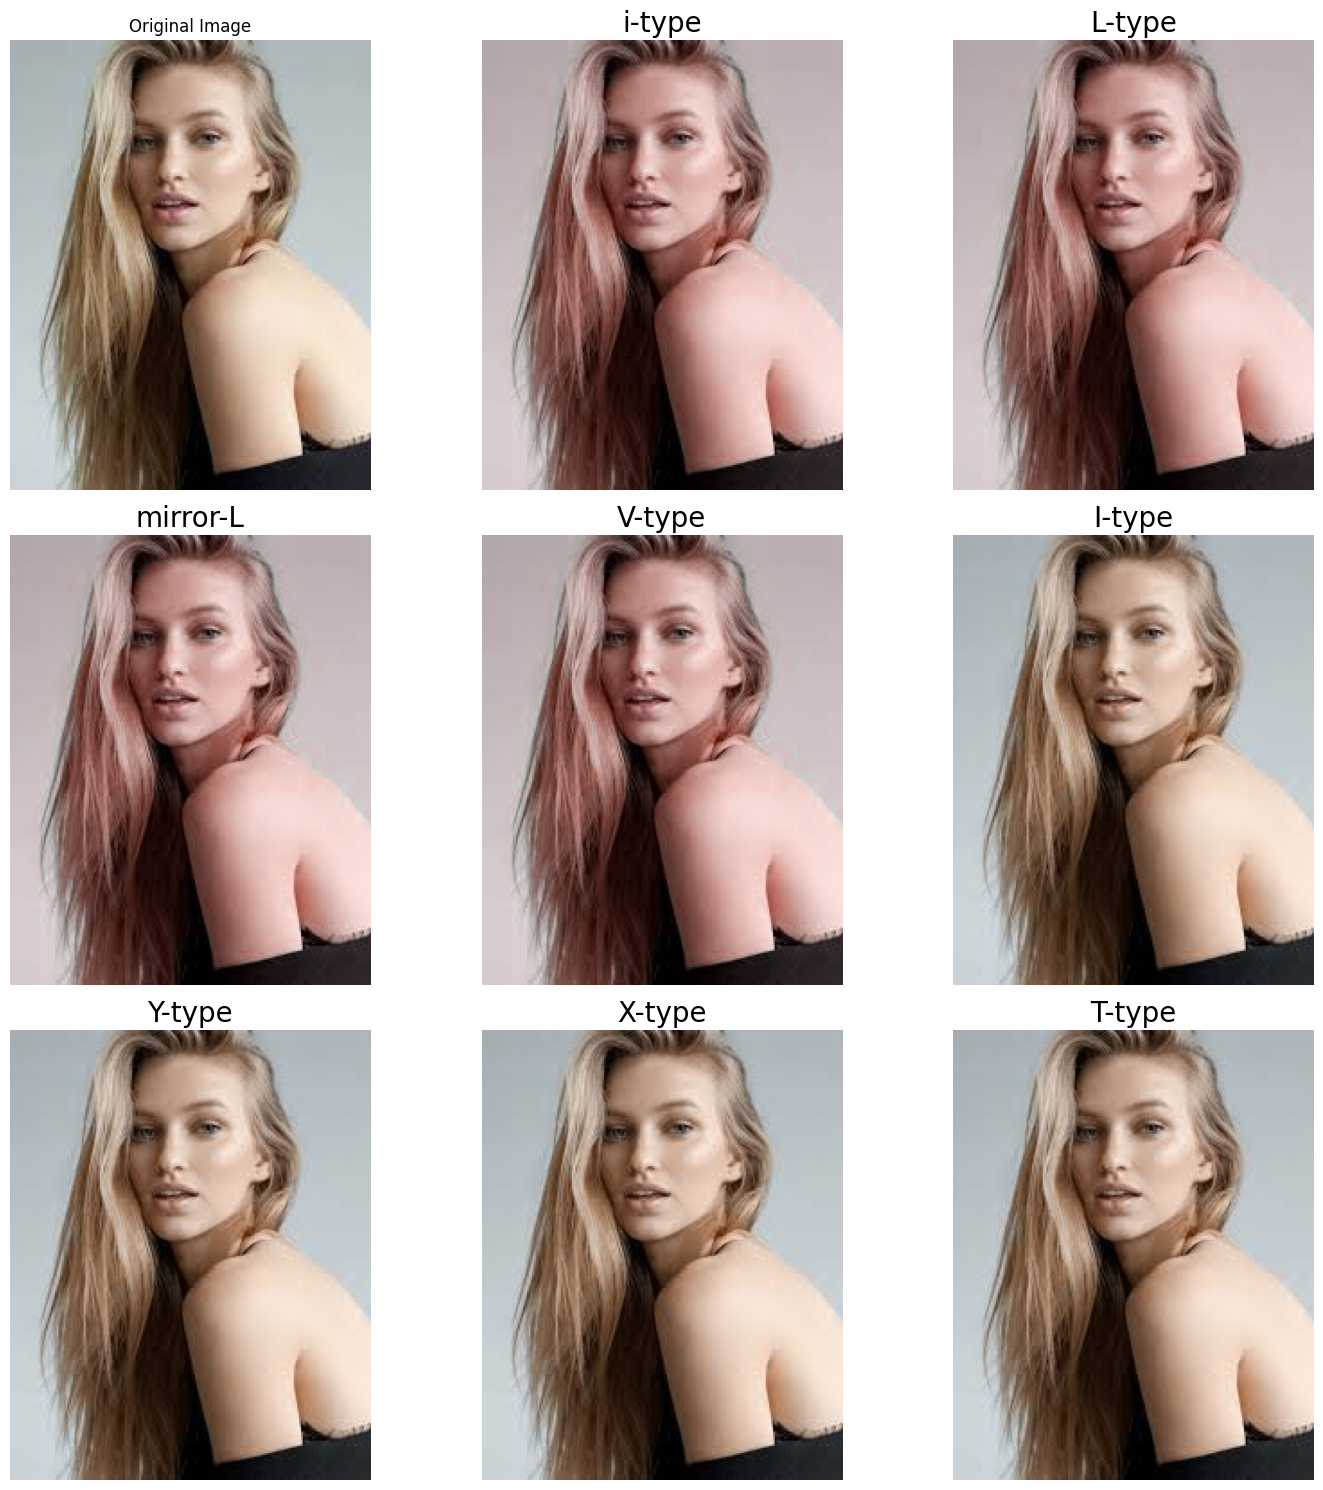

Harmonized image saved to: output_harmonized_image2.jpg


In [22]:
input_image_path = 'input/Model.jpeg'
output_image_path = 'output_harmonized_image2.jpg'

harmonize_image(input_image_path, output_image_path)


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_radial_hue_subplot(ax, data_hue, title):
    """
    Plots a radial hue distribution in a subplot.
    """
    theta = np.linspace(0, 2 * np.pi, 180)  # 180 hue values
    radius = np.ones_like(theta)
    colors = [plt.cm.hsv(i / 180) for i in range(180)]

    # Plot hue wheel
    for i in range(180):
        ax.plot([theta[i], theta[i]], [0, radius[i]], color=colors[i], lw=2)

    # Plot hue distribution
    unique_hues, counts = np.unique(data_hue.flatten(), return_counts=True)
    hue_angles = unique_hues * 2 * np.pi / 180
    normalized_counts = counts / counts.max()

    for angle, r in zip(hue_angles, normalized_counts):
        ax.plot([angle, angle], [0, r], color='black', lw=1)

    ax.set_title(title, va='bottom')

def harmonize_image(input_image_path, output_image_path):
    """
    Harmonizes an image based on color harmony principles, plots harmonized images,
    and their corresponding radial hue distributions.

    Args:
        input_image_path (str): Path to the input image file.
        output_image_path (str): Path where the best harmonized image will be saved.
    """

    Img = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    if Img is None:
        raise FileNotFoundError(f"Could not read image: {input_image_path}")

    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV)  # HSV Space

    weight = np.ones((Img.shape[0], Img.shape[1]))
    Result = np.zeros((8, 3))  # 8 harmony types
    harmonized_images = []

    for m in range(8):
        print(f"Processing {type_m[m]}...")

        Result[m] = brent(Img, m, weight)
        print(f"{type_m[m]}: F = {Result[m][0]}, Alpha = {Result[m][2]}")

        tmp_img = Img.copy()
        harm_shift(tmp_img, m, Result[m][2], 0.5)

        harmonized_bgr = cv2.cvtColor(tmp_img, cv2.COLOR_HSV2BGR)
        harmonized_images.append((harmonized_bgr, tmp_img[:, :, 0]))

    # Create a composite image for the harmonized images
    fig1, axes1 = plt.subplots(3, 3, figsize=(15, 15))
    axes1[0, 0].imshow(cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB))
    axes1[0, 0].set_title('Original Image', fontsize=15)
    axes1[0, 0].axis('off')

    for i, (img_bgr, _) in enumerate(harmonized_images):
        row = (i + 1) // 3
        col = (i + 1) % 3
        axes1[row, col].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        axes1[row, col].set_title(f'{type_name[i]}', fontsize=12)
        axes1[row, col].axis('off')

    fig1.tight_layout()
    fig1.savefig('harmonized_images.png')
    plt.show()

    # Create a composite image for the radial hue plots
    fig2, axes2 = plt.subplots(3, 3, subplot_kw={'projection': 'polar'}, figsize=(15, 15))
    plot_radial_hue_subplot(axes2[0, 0], Img[:, :, 0], 'Original Image')

    for i, (_, img_hue) in enumerate(harmonized_images):
        row = (i + 1) // 3
        col = (i + 1) % 3
        plot_radial_hue_subplot(axes2[row, col], img_hue, f'{type_name[i]}')

    fig2.tight_layout()
    fig2.savefig('radial_hue_plots.png')
    plt.show()

    # Save the best harmonized image
    best_harmony = Result[0]
    M, Alpha = int(best_harmony[1]), best_harmony[2]
    harm_shift(Img, M, Alpha, 0.5)
    Img_harmonized = cv2.cvtColor(Img, cv2.COLOR_HSV2BGR)
    cv2.imwrite(output_image_path, Img_harmonized)
    print(f"Harmonized image saved to: {output_image_path}")


Processing i type...
i type: F = 897458.7662606682, Alpha = 26.953125
Processing L type...
L type: F = 303996.4424172527, Alpha = 57.65625
Processing mirror-L type...
mirror-L type: F = 321240.476723005, Alpha = 264.375
Processing V type...
V type: F = 540343.2336221467, Alpha = 64.921875
Processing I type...
I type: F = 134615.89748489886, Alpha = 24.84375
Processing Y type...
Y type: F = 58875.52839698707, Alpha = 198.984375
Processing X type...
X type: F = 12929.26689008319, Alpha = 26.71875
Processing T type...
T type: F = 105290.48732983031, Alpha = 100.078125


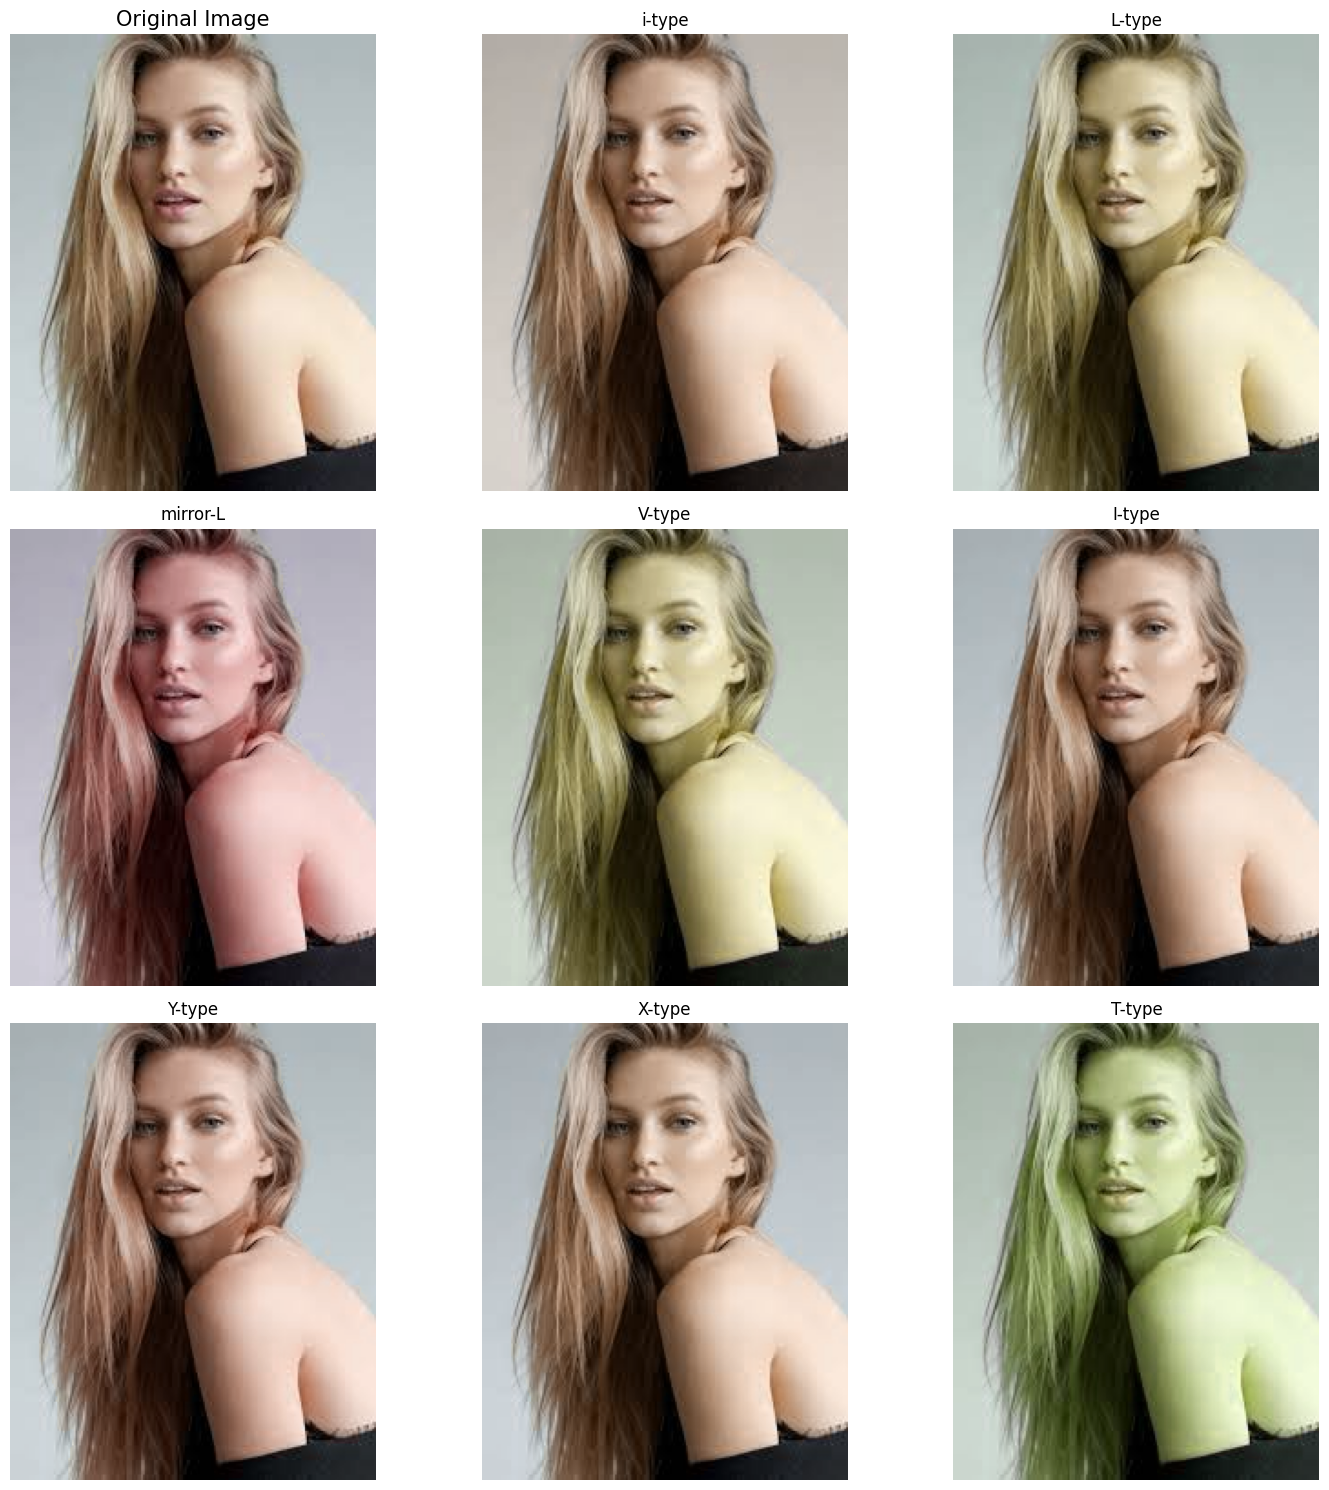

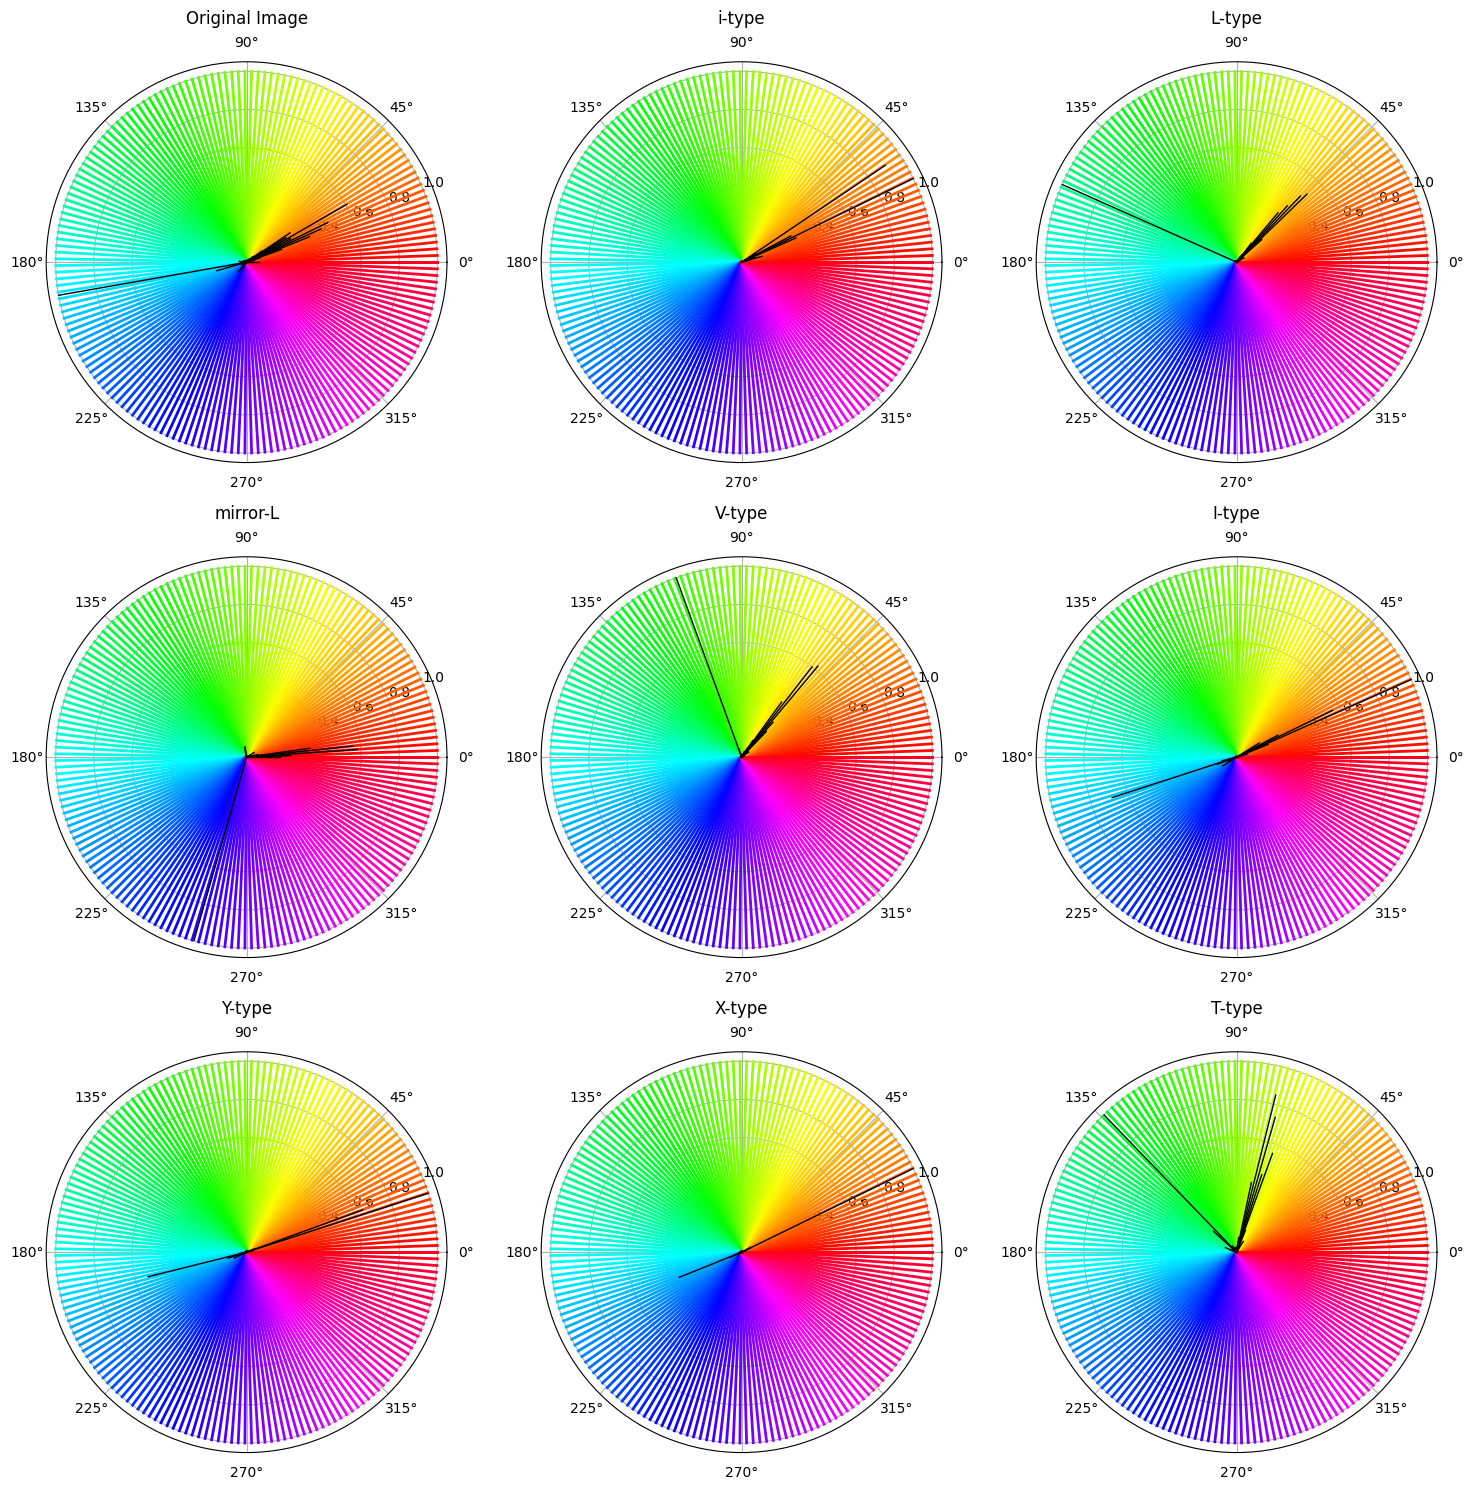

Harmonized image saved to: output_harmonized_image2.jpg


In [14]:
input_image_path = 'input/Model.jpeg'
output_image_path = 'output_harmonized_image2.jpg'

harmonize_image(input_image_path, output_image_path)


## Harmonizing Video

In [26]:
from tqdm import tqdm 

def harmonize_video(input_video_path, output_video_path, harmony_type, harmonization_function):
    """
    Applies color harmonization on each frame of the video based on the specified harmony type.
    
    Args:
        input_video_path (str): Path to the input video file.
        output_video_path (str): Path where the processed video will be saved.
        harmony_type (int): The harmony type to apply (from 0 to 7 corresponding to the types).
        harmonization_function (function): The function to apply the harmonic shift.
    """

    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video: {input_video_path}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    with tqdm(total=total_frames, desc="Processing video", unit="frame") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  
            
            frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # HSV Color Space

            weight = np.ones((frame_hsv.shape[0], frame_hsv.shape[1]))

            result = brent(frame_hsv, harmony_type, weight)
            M, Alpha = int(result[1]), result[2]

            harmonized_frame_hsv = frame_hsv.copy()
            harmonization_function(harmonized_frame_hsv, M, Alpha, 0.5)

            harmonized_frame_bgr = cv2.cvtColor(harmonized_frame_hsv, cv2.COLOR_HSV2BGR)

            out.write(harmonized_frame_bgr)

            pbar.update(1)
            print(1)

    cap.release()
    out.release()
    print(f"Harmonized video saved to: {output_video_path}")

In [27]:
input_video_path = 'goat.mp4'
output_video_path = 'goat_Harmonized_type8.mp4'
harmony_type = 7 # T type (7) and L (1) type done.
harmonization_function = harm_shift
harmonize_video(input_video_path, output_video_path, harmony_type, harmonization_function)

Processing video:   0%|          | 0/162 [00:00<?, ?frame/s]


KeyboardInterrupt: 